# Train autoencoder

In this notebook, train an autoencoder on the Tetris dataset.

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


import metrics
from recording import FileBasedDatabaseWithEvents
from engines import EVENT_NAMES

In [2]:
NUM_CELL_TYPES = 8
NUM_EVENT_TYPES = 5

class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self._db = FileBasedDatabaseWithEvents(path)

    def __len__(self):
        return len(self._db)

    def __getitem__(self, idx):
        boards, events = self._db[idx]
        b = self._transform_board(boards[0]) # Just take one board
        return b
    
    def _transform_board(self, board):
        board = torch.tensor(board, dtype=torch.long)
        board = F.one_hot(board, NUM_CELL_TYPES) # One-hot encode the cell types
        board = board.type(torch.float) # Convert to floating-point
        board = board.permute((2, 0, 1)) # Move channels/classes to dimension 0
        return board

In [3]:
# Put datasets in memory for faster training
train_dataset = list(RecordingDataset(os.path.join("data", "tetris_emulator", "train")))
test_dataset = list(RecordingDataset(os.path.join("data", "tetris_emulator", "test")))
batch_size = 12 # Was 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

b = next(iter(train_dataloader))
print(f"b: shape {b.shape}, dtype {b.dtype}")

b: shape torch.Size([12, 8, 22, 10]), dtype torch.float32


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device {device}")

Using device cuda


In [5]:
real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, gen, loss_fn, optimizer_gen):
    gen.train()

    size = len(dataloader.dataset)
    for batch, b in enumerate(dataloader):
        b = b.to(device)

        gen.zero_grad()
        # Reconstruct some examples
        b_pred = gen(b)
        # Calculate the generator's loss based on this output
        err_gen = loss_fn(b_pred, b)
        # Calculate gradients for generator
        err_gen.backward()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if batch % 30 == 0:
            current = batch * dataloader.batch_size + batch_size
            print(f"[{current}/{size}] G loss: {err_gen.item():.4f}")


def test_loop(split_name, dataloader, gen, loss_fn, tb_writer, epoch):
    gen.eval()

    loss_gen = 0.0
    cell_accuracy = metrics.CellAccuracy()
    board_accuracy = metrics.BoardAccuracy()

    num_batches = len(dataloader)
    with torch.no_grad():        
        for batch, b in enumerate(dataloader):
            b = b.to(device)

            b_pred = gen(b)
            
            loss_gen += loss_fn(b_pred, b).item()

            classes_b = torch.argmax(b, dim=1)
            classes_b_pred = torch.argmax(b_pred, dim=1)
            cell_accuracy.update_state(classes_b_pred, classes_b)
            board_accuracy.update_state(classes_b_pred, classes_b)


    loss_gen /= len(dataloader.dataset)

    print(f"{split_name} error: \n G loss: {loss_gen:>8f}, cell accuracy: {(cell_accuracy.result()):>0.1%}, board accuracy: {(board_accuracy.result()):>0.1%} \n")

    tb_writer.add_scalar(f"Loss/{split_name}", loss_gen, epoch)
    tb_writer.add_scalar(f"Cell accuracy/{split_name}", cell_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Board accuracy/{split_name}", board_accuracy.result(), epoch)

In [6]:
def train(gen_factory, epochs, learning_rate):

    gen = gen_factory()

    loss_fn = nn.MSELoss() # BCE loss causes instability when the loss gets too small
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "autoencoder")
    log_subdir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb_writer = SummaryWriter(log_subdir)

    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch}\n-------------------------------")
            train_loop(train_dataloader, gen, loss_fn, optimizer_gen)
            test_loop("train", train_dataloader, gen, loss_fn, tb_writer, epoch)
            test_loop("test", test_dataloader, gen, loss_fn, tb_writer, epoch)
            gen_zero_grads = 0
            for name, weight in gen.named_parameters():
                tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
                if weight.grad is not None:
                    tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
                    gen_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
            tb_writer.add_scalar(f"Zero gradients", gen_zero_grads, epoch)
    finally:
        tb_writer.close()
        
    print("Done!")
    return gen

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
NUM_RANDOM_INPUTS = 4


class Conv2dLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, use_batch_norm=False, negative_slope=0.0):
        super().__init__()

        self.use_batch_norm = use_batch_norm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=(not use_batch_norm))
        nn.init.kaiming_uniform_(self.conv.weight, a=negative_slope)
        if not use_batch_norm:
            nn.init.constant_(self.conv.bias, 0.01)

        if use_batch_norm:
            self.norm = nn.BatchNorm2d(out_channels)

        self.relu = nn.LeakyReLU(negative_slope)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_batch_norm:
            x = self.norm(x)
        x = self.relu(x)
        return x


class ConvTranspose2dLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, use_batch_norm=False, negative_slope=0.0):
        super().__init__()

        self.use_batch_norm = use_batch_norm

        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, bias=(not use_batch_norm))
        nn.init.kaiming_uniform_(self.conv.weight, a=negative_slope)
        if not use_batch_norm:
            nn.init.constant_(self.conv.bias, 0.01)

        if use_batch_norm:
            self.norm = nn.BatchNorm2d(out_channels)
            
        self.relu = nn.LeakyReLU(negative_slope)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_batch_norm:
            x = self.norm(x)
        x = self.relu(x)
        return x


class LinearLeakyReLU(nn.Module):
    def __init__(self, in_features, out_features, negative_slope=0.0):
        super().__init__()

        self.linear = nn.Linear(in_features, out_features)
        nn.init.kaiming_uniform_(self.linear.weight, a=negative_slope)
        nn.init.constant_(self.linear.bias, 0.01)

        self.relu = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x


class GameganAutoencoder(nn.Module):
    def __init__(self, use_batch_norm=False, leak=0.0):
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.leak = leak

        self.board_encoder = nn.Sequential(
            Conv2dLeakyReLU(NUM_CELL_TYPES, 64, kernel_size=2, stride=2, use_batch_norm=use_batch_norm, negative_slope=leak),
            Conv2dLeakyReLU(64, 64, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            Conv2dLeakyReLU(64, 64, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            nn.Flatten(start_dim=1),
            LinearLeakyReLU(448, 256, negative_slope=leak)
        )

        self.renderer = nn.Sequential(
            LinearLeakyReLU(256, 448, negative_slope=leak),
            nn.Unflatten(dim=1, unflattened_size=(64, 7, 1)),
            ConvTranspose2dLeakyReLU(64, 64, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            ConvTranspose2dLeakyReLU(64, 64, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            nn.ConvTranspose2d(64, NUM_CELL_TYPES, kernel_size=2, stride=2),
            nn.Softmax(dim=1),
        )

    def forward(self, b):
        # Encode board state
        s = self.board_encoder(b)

        # Render new board
        y = self.renderer(s)
        return y


print(f"Parameters: {count_parameters(GameganAutoencoder())}")

Parameters: 381960


In [9]:
try:
    del gen
except NameError:
    pass

gen = train(
    gen_factory=lambda: GameganAutoencoder(use_batch_norm=True, leak=0.2).to(device),
    epochs=2000,
    learning_rate=1e-4
)

Epoch 0
-------------------------------
[12/8000] G loss: 0.1161
[372/8000] G loss: 0.1084
[732/8000] G loss: 0.1003
[1092/8000] G loss: 0.0933
[1452/8000] G loss: 0.0851
[1812/8000] G loss: 0.0799
[2172/8000] G loss: 0.0738
[2532/8000] G loss: 0.0688
[2892/8000] G loss: 0.0649
[3252/8000] G loss: 0.0586
[3612/8000] G loss: 0.0551
[3972/8000] G loss: 0.0564
[4332/8000] G loss: 0.0489
[4692/8000] G loss: 0.0475
[5052/8000] G loss: 0.0449
[5412/8000] G loss: 0.0454
[5772/8000] G loss: 0.0456
[6132/8000] G loss: 0.0389
[6492/8000] G loss: 0.0372
[6852/8000] G loss: 0.0376
[7212/8000] G loss: 0.0359
[7572/8000] G loss: 0.0381
[7932/8000] G loss: 0.0402
train error: 
 G loss: 0.002951, cell accuracy: 79.8%, board accuracy: 0.0% 

test error: 
 G loss: 0.002959, cell accuracy: 79.6%, board accuracy: 0.0% 

Epoch 1
-------------------------------
[12/8000] G loss: 0.0329
[372/8000] G loss: 0.0329
[732/8000] G loss: 0.0367
[1092/8000] G loss: 0.0318
[1452/8000] G loss: 0.0347
[1812/8000] G los

In [10]:
from collections import namedtuple
import bisect

Reconstruction = namedtuple("Reconstruction", ["loss", "b", "b_pred"])

In [11]:
def find_worst_reconstructions(gen, dataloader, count):
    reconstructions = []

    for _ in range(count):
        reconstructions.append(Reconstruction(loss=float("-inf"), b=None, b_pred=None))

    def maybe_insert_reconstruction(rec):
        bisect.insort(reconstructions, rec, key=lambda x: -x.loss)
        reconstructions.pop()

    gen.eval()
    loss_fn = nn.MSELoss()

    with torch.no_grad():
        for batch, b in enumerate(dataloader):
            batch_size = b.size(0)

            b_pred = gen(b.to(device)).cpu()

            for i in range(batch_size):
                loss = loss_fn(b_pred[i], b[i])
                rec = Reconstruction(loss, b[i], b_pred[i])
                maybe_insert_reconstruction(rec)
    
    return reconstructions

In [12]:
from tetris import CELL_COLORS

def render_board(board):
    board = board.argmax(0)
    height, width = board.shape
    img = np.zeros((3, height, width))
    for row in range(height):
        for col in range(width):
            img[:, row, col] = CELL_COLORS[board[row, col]]
    img /= 255.0
    return img

pygame 2.4.0 (SDL 2.26.4, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
import matplotlib.pyplot as plt

def show_reconstruction(b_pred, b):
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"Prediction vs reality")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Predicted")
    axs[1].set_title("Reality")

    axs[0].imshow(render_board(b_pred).transpose((1, 2, 0)), vmin=0, vmax=1)
    axs[1].imshow(render_board(b).transpose((1, 2, 0)), vmin=0, vmax=1)

    plt.show()

In [14]:
reconstructions = find_worst_reconstructions(gen, test_dataloader, 5)

Loss: 0.007475133053958416


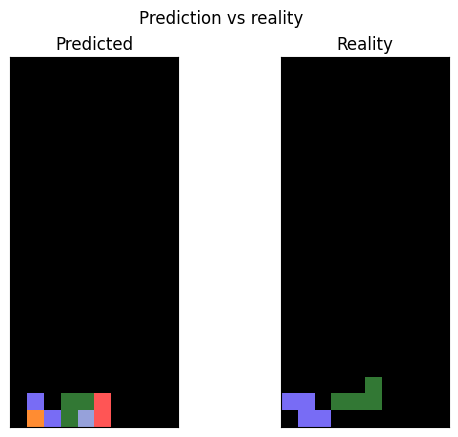

Loss: 0.007174932863563299


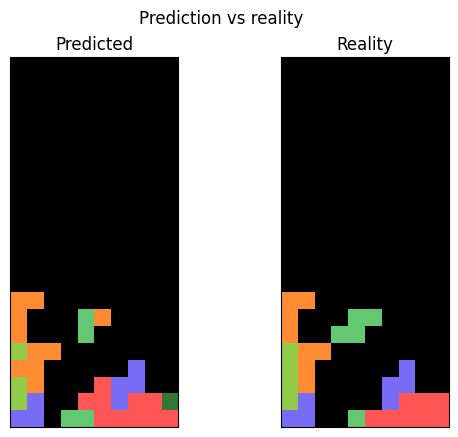

Loss: 0.007090744096785784


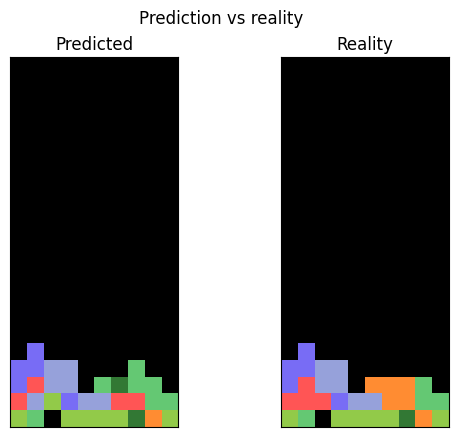

Loss: 0.006777326576411724


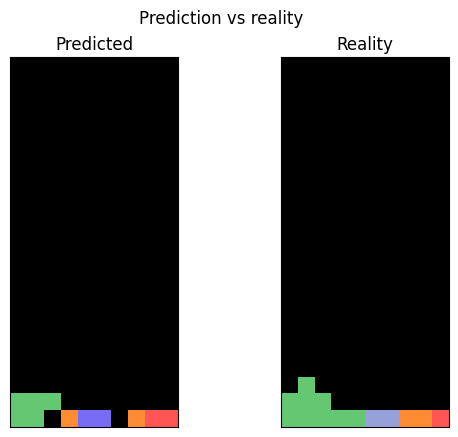

Loss: 0.006245555821806192


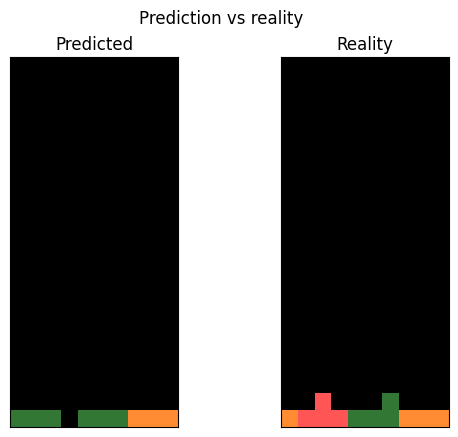

In [15]:
for rec in reconstructions:
    print("Loss:", rec.loss.item())
    show_reconstruction(rec.b_pred, rec.b)

In [16]:
torch.save(gen.state_dict(), "gamegan_autoencoder.pth")